In [548]:
import pandas as pd
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
# read in data:
traindata = pd.read_csv('traindata.csv')
test= pd.read_csv('test.csv')
# df = df.drop(columns='Unnamed: 0')
# df.reset_index(drop=True)

<h2>Data exploration </h2>

In [550]:
#Graph some relationship between the target and parameters 

#the rise of the movie budgets vs ROi, director age vs budgets -- do you only trust old enough directors? 


bx = traindata[['budget','year']].groupby('year').mean().reset_index()


# import plotly.express as px 
# fig=px.bar(bx, x='year', y='budget')

# fig.update_layout({
# ‘plot_bgcolor’: ‘rgba(0, 0, 0, 0)’,
# ‘paper_bgcolor’: ‘rgba(0, 0, 0, 0)’,
# })

# fig.show()




In [551]:
y1964=traindata[traindata['year']==1964]
y1964[['nominee', 'budget']]

,nominee,budget
70,America America,NaN
87,Cleopatra,3.584249e+08
136,Lilies Of The Field,1.955045e+06
137,Tom Jones,8.146019e+06
431,How The West Was Won,1.221903e+08


In [552]:
bx = traindata[['budget','year']].groupby('year').mean().reset_index()

px.bar(bx, x='year', y='budget', title='Average nominated film budget (estimated, adjust for inflation)')



In [553]:
bx = traindata[['dir_age','year']].groupby('year').mean().reset_index()

px.bar(bx, x='year', y='dir_age')

In [554]:
genres=['biography', 'drama', 'comedy',
       'adventure', 'film-noir', 'mystery', 'action', 'crime', 'horror',
       'family', 'animation', 'western', 'romance', 'fantasy', 'thriller',
       'war', 'history', 'music', 'sport', 'musical', 'sci-fi']
result =[]
for genre in genres: 
    a=pd.crosstab(traindata[genre], traindata['winner_bool'])
    no_win=a[0][1]
    n_wins = a[1][1]
    pct_wins=n_wins/(no_win+n_wins)
    result.append([genre, total, n_wins, pct_wins])
    
wins_by_genre=pd.DataFrame(result, columns=['genre', 'total','n_wins','pct_wins'])
    

In [555]:
px.bar(wins_by_genre.sort_values(by='pct_wins'), x='genre', y='pct_wins', title='Percent Best Picture Wins by genre all-time')

In [556]:
genres=['biography', 'drama', 'comedy',
       'adventure', 'mystery', 'action', 'crime',
       'family','western', 'romance', 'fantasy', 'thriller',
       'war', 'history', 'music', 'sport', 'musical', 'sci-fi']
result =[]
data=traindata[traindata['year']>1999]
for genre in genres: 
#    if genre in 
        a=pd.crosstab(data[genre], data['winner_bool'])
        no_win=a[0][1]
        n_wins = a[1][1]
        pct_wins=n_wins/(no_win+n_wins)
        vs_mean=pct_wins-data['winner_bool'].mean()
        result.append([genre, total, n_wins, pct_wins, vs_mean])
    
wins_by_genre2=pd.DataFrame(result, columns=['genre', 'total','n_wins','pct_wins', 'vs_mean'])
    
px.bar(wins_by_genre2.sort_values(by='vs_mean'), x='genre', y='vs_mean', title='Percent Best Picture Wins by genre (2000-2019)')

<h2>Baseline</h2>

In [557]:
#My data baseline -- the majority calss -- is False

traindata['winner_bool'].value_counts()


False    359
True      78
Name: winner_bool, dtype: int64

In [558]:
#Separate into train, and val
train=traindata[traindata['year']<=2005]
val=traindata[traindata['year']>2005]

In [559]:
#Select target and features 
target='winner_bool'
features=train.columns.drop([target, 'winner', 'nconst_x','nconst_y','award', 'nominee', 'movie', 'year',
                             'year_film', 'year_film2', 'year_film3',
                              'tconst', 'primarytitle', 'startyear', 
                            'directors', 'writers', 'director','birthyear', 
                             'name', 'release_day', 'cpi_multiplier','opening_usa_day','release_day_of_month',
                             'runtimeminutes','music', 'sport', 'fantasy', 'thriller', 'film-noir', 'mystery', 
                             'action','musical', 'sci-fi','family', 'western','animation', 'horror',
                             'world','gross','history', 
                           'n_globes', 'crime', 'war', 'history', 'comedy','genres','romance',     
                             'biography', 'drama', 'adventure'
#                             'comedy', 
#                           'budget',
#                            'romance',   'release_month',
                            ])

X_train=train[features]
X_val=val[features]
X_test=test[features]

y_train=train[target]
y_val=val[target]

In [560]:
1- traindata['winner_bool'].mean()

0.8215102974828375

<h2>Fit a linear model </h2>

This is a classification problem, so I'm going to use Logistic Regression 

In [561]:

from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


mypipeline= make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LogisticRegression(random_state=42)   
)
    
mypipeline.fit(X_train, y_train)
print(f'Accuracy score: {mypipeline.score(X_val, y_val)}')


Accuracy score: 0.8165137614678899


In [562]:
y_pred=mypipeline.predict(X_val)

In [563]:
from sklearn.metrics import classification_report, confusion_matrix

#The classification_report will give precision, recall, and F1
print(classification_report(y_val, y_pred))

#Or we can calculate the metrics from the confusion matrix
pd.DataFrame(confusion_matrix(y_val, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

       False       0.92      0.86      0.89        95
        True       0.35      0.50      0.41        14

    accuracy                           0.82       109
   macro avg       0.64      0.68      0.65       109
weighted avg       0.85      0.82      0.83       109



,Predicted Negative,Predicted Positive
Actual Negative,82,13
Actual Positive,7,7


<h2>Fit Random Forest model </h2>

In [564]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


mypipeline= make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=20, n_estimators=50)   
)
    
mypipeline.fit(X_train, y_train)
print(f'Accuracy score: {mypipeline.score(X_val, y_val)}')

Accuracy score: 0.8440366972477065


Area under the Receiver Operating Characteristic curve: 0.7327067669172932


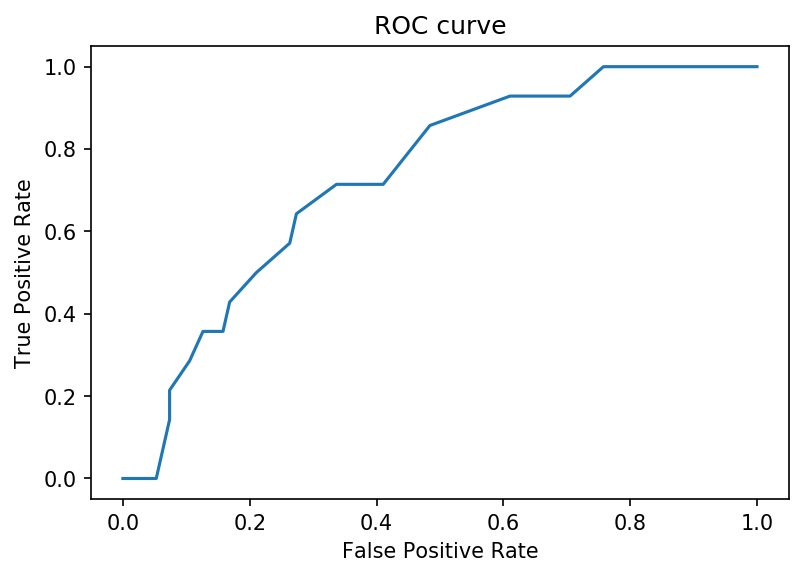

In [565]:
y_pred_proba=mypipeline.predict_proba(X_val)[:,1]


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

#get the false-positive and true positives
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

#plot it
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_val, y_pred_proba))

In [566]:
!pip install eli5

from eli5.sklearn import PermutationImportance

In [567]:

encoder=mypipeline.named_steps['ordinalencoder']
X_train_encoded=encoder.transform(X_train)
X_val_encoded=encoder.transform(X_val)
X_test_encoded=encoder.transform(X_test)


imputer=mypipeline.named_steps['simpleimputer']
X_train_imputed=pd.DataFrame(imputer.fit_transform(X_train_encoded),columns=X_train_encoded.columns)
X_val_imputed=pd.DataFrame(imputer.transform(X_val_encoded),columns=X_val_encoded.columns)
X_test_imputed=pd.DataFrame(imputer.transform(X_test_encoded),columns=X_test_encoded.columns)



import eli5
permuter = PermutationImportance(
    mypipeline,
    n_iter=5,
    random_state=42
    
)


permuter.fit(X_val_imputed, y_val)
feature_names=X_val_encoded.columns.to_list()
#Plot

eli5.show_weights(
    permuter,
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0073 ± 0.0243,actor_in_a_supporting_role_nomination
0.0037 ± 0.0187,actress_in_a_leading_role_nomination
0.0018 ± 0.0214,dir_age
0 ± 0.0000,rating
0 ± 0.0000,is_woman
0 ± 0.0000,actress_in_a_supporting_role_nomination
-0.0037 ± 0.0275,directing_nomination
-0.0037 ± 0.0187,numvotes
-0.0055 ± 0.0220,metascore
-0.0073 ± 0.0336,budget


<h2>Partial dependence plots </h2>

In [568]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi']=72

!pip install pdpbox

In [569]:
%matplotlib inline
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'dir_age'

isolated=pdp_isolate(
    model=mypipeline.named_steps['randomforestclassifier'],
    dataset=X_val_imputed,
    model_features=X_val_encoded.columns,
    feature=feature
)

(<Figure size 2250x1425 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a26a1a990>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a26a4fa50>})

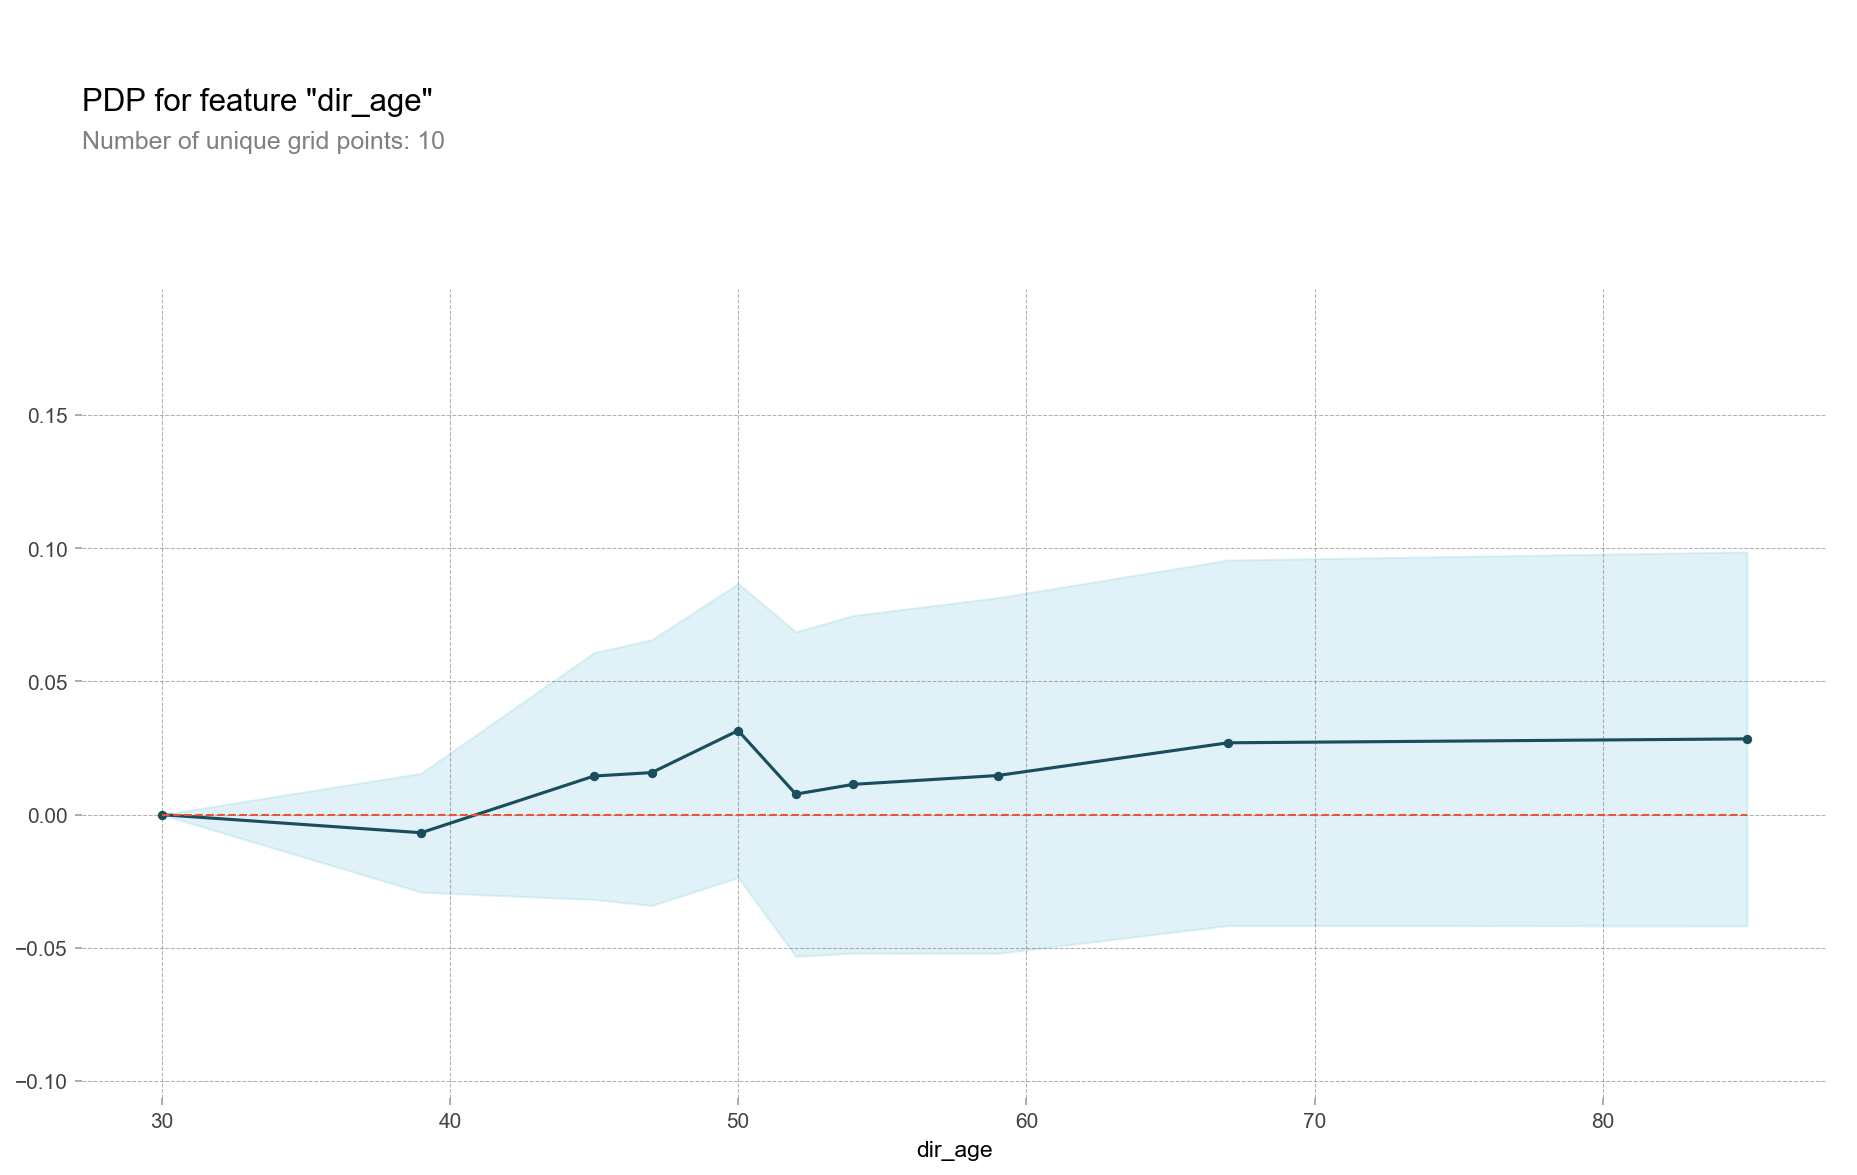

In [570]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
pdp_plot(isolated, feature_name=feature)

#from pdp.plt import savefig



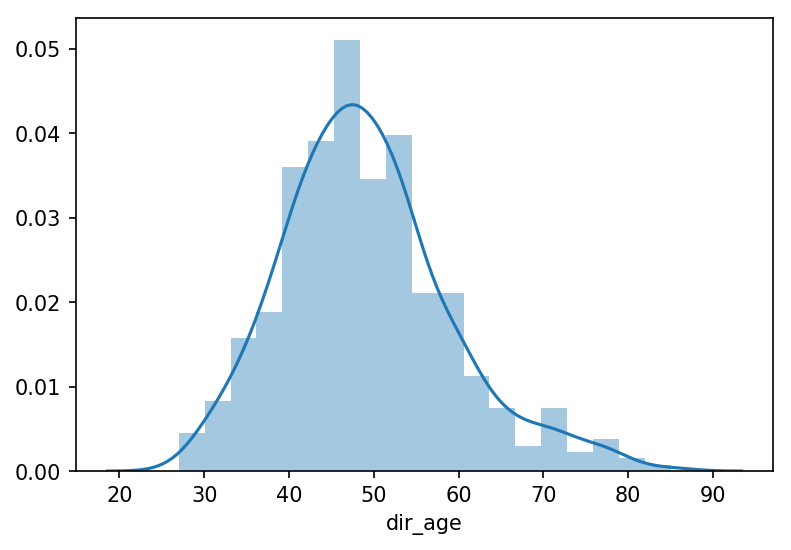

In [571]:
import seaborn as sns 

sns.distplot(traindata['dir_age'].dropna());

<h3> PDP plot 2 features </h3>

In [600]:

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['dir_age', 'averagerating']

interaction = pdp_interact(
    model=mypipeline.named_steps['randomforestclassifier'], 
    dataset=X_val_imputed,
    model_features=X_val_encoded.columns,
    features=features

)

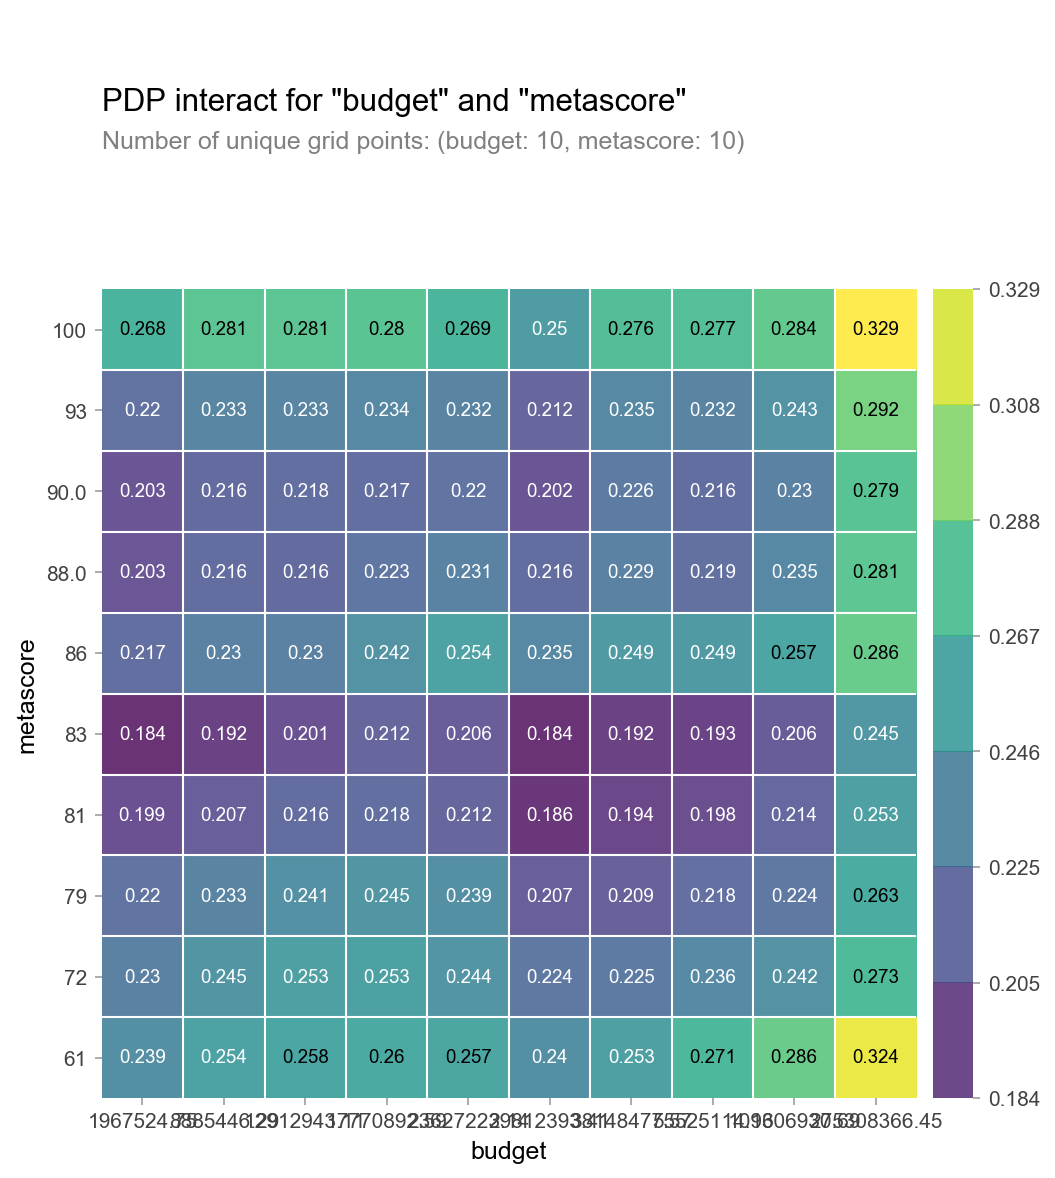

In [599]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features);

<h2>Shapley values </h2>

We're going to be using real test data for 2020 --  we still do not know who is the winner!

In [580]:
import numpy as np

y_pred = pd.Series(mypipeline.named_steps['randomforestclassifier'].predict(X_test_imputed))
y_pred_proba = pd.Series(mypipeline.named_steps['randomforestclassifier'].predict_proba(X_test_imputed)[:,1])


df = pd.DataFrame({
    'name': test['nominee'],
    'pred_proba': y_pred_proba,
    'y_pred': y_pred
    
})

df

,name,pred_proba,y_pred
0,Ford V Ferrari,0.10,False
1,The Irishman,0.34,False
2,Jojo Rabbit,0.00,False
3,Joker,0.58,True
4,Little Women,0.12,False
5,Marriage Story,0.14,False
6,1917,0.18,False
7,Once Upon A Time... In Hollywood,0.44,False
8,Parasite,0.34,False


In [583]:
px.bar(df.sort_values(by='pred_proba'), y='name', x='pred_proba', orientation='h', title='Joker predicted to win Best Picture 2020')

In [584]:
row =pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns).iloc[[0]]

In [585]:
!pip install shap
import shap

In [586]:
explainer=shap.TreeExplainer(mypipeline.named_steps['randomforestclassifier'])
shap_value=explainer.shap_values(row)

In [587]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_value[1],
    features=row,
#     link='logit'
)

In [588]:
row =pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns).iloc[[3]]
explainer=shap.TreeExplainer(mypipeline.named_steps['randomforestclassifier'])
shap_value=explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_value[1],
    features=row,
#     link='logit'
)

In [589]:
shap_value[1]

array([[ 5.82092505e-02, -2.88188841e-02, -2.34664074e-03,
         5.36619216e-04,  5.39459845e-02,  4.23997572e-02,
         9.73032225e-02,  1.17963676e-01,  9.49885940e-03,
         4.85902045e-05, -8.25839249e-03, -1.24716081e-02,
         9.78304799e-03,  6.08128938e-02, -1.59844249e-02]])

In [590]:
explainer.expected_value

array([0.80262195, 0.19737805])

In [591]:
y_val_pred=pd.Series(mypipeline.predict(X_val))
y_val_pred_proba=pd.Series(mypipeline.predict_proba(X_val)[:,1])
y_val_line=(y_val.reset_index())['winner_bool']
print(y_val_pred.shape, y_val_line.shape)

confusion=pd.DataFrame({'y_val_pred':y_val_pred, 'y_val':y_val_line, 'y_val_pred_proba':y_val_pred_proba})
# pd.crosstab(confusion[:,0])
print(confusion.shape)

(109,) (109,)
(109, 3)


In [593]:
pd.crosstab(confusion['y_val_pred'], confusion['y_val'])

y_val,False,True
y_val_pred,,
False,92,14
True,3,0


In [594]:
confusion[confusion['y_val']]

,y_val_pred,y_val,y_val_pred_proba
5,False,True,0.42
31,False,True,0.42
39,False,True,0.40
44,False,True,0.32
58,False,True,0.24
62,False,True,0.20
65,False,True,0.12
68,False,True,0.30
74,False,True,0.36
87,False,True,0.28


In [595]:
confusion['y_val_pred_proba'].mean()

0.21724770642201835

In [596]:
(y_val.reset_index())['winner_bool']

0      False
1      False
2      False
3      False
4      False
       ...  
104    False
105    False
106     True
107    False
108     True
Name: winner_bool, Length: 109, dtype: bool